In [272]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
nlp = spacy.load('en_core_web_sm')
import score as sc
import time
from sklearn.metrics import confusion_matrix
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter

In [207]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [209]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [210]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [298]:
stances_tr, stances_val = train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10768, 3), (2659, 3))

In [299]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
stances_tr = pd.concat([stances_tr, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [213]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [337]:
def preprocess(text, strip_colon = False):
    text = text.replace("' ",' ')
    text = text.replace(" '",' ')
    text = text.lower()
    if strip_colon:
        split = text.split(":")
        if len(split) > 1:
            if len(split[0]) > len(split[1]):
                text = split[0]
            else:
                text = split[1]
    return text

In [215]:
neg_words = set(["n't", "not", "no", "never", "nobody", "non"])
doubt_words = set(['fake','fraud', 'hoax', 'false', 'deny', 'denies', 'despite', 'nope', 'doubt', 'bogus', 'debunk', 'prank', 'retract', 'scam'])
nr_words = neg_words.union(doubt_words)

In [216]:
def get_subj(doc):
    """
    get subjects of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    """
    subjs = {}
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2:
            if chunk.root.text not in subjs:
                subjs[chunk.root.text] = set([chunk.root.text])
            subjs[chunk.root.text].add(chunk.text)
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [217]:
def get_svo(doc):
    """
    input: Spacy processed document
    output: 3x2 tuple, each entry contains the word, and whether that word or any of it's children are negating words
    ex: "he did not hit the ball" -> (("-pron-", False),("hit", True), ("ball", False))
    """
    def check_neg(tok):
        neg_children = len([c.lemma_.lower() for c in tok.children if c.lemma_.lower() in neg_words])
        return neg_children > 0 or (tok.lemma_.lower() in neg_words)
    s = (None, False)
    v = (None, False)
    o = (None, False)
    verb = None
    for token in doc:
        if token.dep_ == 'ROOT':
            verb = token.head
            break
    v = (verb.lemma_.lower(), check_neg(verb))
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    for child in verb.children:
        if child.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","expl"]:
            s = (child.lemma_.lower(), check_neg(child))
        elif child.dep_ in ["dobj", "dative", "attr", "oprd"]:
            o = (child.lemma_.lower(), check_neg(child))
    return (s,v,o)

In [218]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        if len(token) > 1:
            for child in token.children:
                if len(child) > 1:
                    edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.Graph(list(edges))
    return graph

In [219]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    custom sentence scoring metric, first sentence will always be returned
    """
    subjects_ = subjects["_vocab"]
    def score_sentence(doc):
        # not very robust right now
        score = 0
        word_count = 0
        for token in doc:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in nr_words:
                score += 0.25
        return score/word_count
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences[1:])]
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n-1]
    top.sort(key = lambda x: x[0])
    result = [sentences[0]] + [s[1] for s in top]
    return result

In [220]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating word
    returns: dictionary with subject as key, and 2-element list of path length and the actual path as the value
    - if a subject does not exist in graph, then result will not include that subject as key
    - if a subject does not have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        if graph.has_node(s) and s not in nr_words:
            results[s] = [None, None] #length of path, path
            for word in nr_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                            results[s][1] = path
                    except:
                        continue
    return results

In [318]:
# https://github.com/CornellDataScience/Summarization/blob/master/textrank2.py
import editdistance
import itertools
import networkx as nx
import nltk


def build_tr_graph(nodes):
    """
    Return networkx graph instance built from nodes
    """
    #initialize graph
    graph = nx.Graph()  
    graph.add_nodes_from(nodes)
    nodePairs = list(itertools.combinations(nodes, 2))

    #add edges weighted by Levenshtein distance
    for pair in nodePairs:
        levDistance = editdistance.eval(pair[0], pair[1])
        graph.add_edge(pair[0], pair[1], weight=levDistance)

    return graph


def extract_sentences(text, clean_sentences=False, language='english'):
    """
    Return list of sentences in text sorted in descending order of importance
    """
    sent_detector = nltk.data.load('tokenizers/punkt/'+language+'.pickle')
    sentence_tokens = sent_detector.tokenize(text.strip())
    graph = build_tr_graph(sentence_tokens)

    calculated_page_rank = nx.pagerank(graph, weight='weight')

    #list of most important sentences first
    sentences = sorted(calculated_page_rank, key=calculated_page_rank.get,
                       reverse=True)

    return sentences

def get_summary_tr(text, numSentences=1):
    '''
    Return summary of text in numSentences sentences (default: 1)
    '''
    sentences = extract_sentences(text)

    if numSentences > len(sentences) or numSentences == 1: summary = sentences[0]
    
    else: 
        summary = ' '.join(sentences[:numSentences])
        summary_words = summary.split()
        dot_indices = [idx for idx, word in enumerate(summary_words) if word.find('.') != -1]
        if dot_indices:
            last_dot = max(dot_indices) + 1
            summary = ' '.join(summary_words[:last_dot])
        else:
            summary = ' '.join(summary_words)
    return summary

In [335]:
h_id = 20
test = nlp(preprocess(list(train_stances.values)[h_id][0]))
test = nlp(preprocess("Hilarious: North Dakota Pays Special Tribute to President Obama"))
print(test)
test_graph = build_graph(test)
test_subj = get_subj(test)
test_svo = get_svo(test)
print(test_subj)
print(get_shortest_path_to_negating(test_graph, test_subj))
print(test_svo)

hilarious: north dakota pays special tribute to president obama
{'dakota': {'north dakota', 'dakota'}, 'tribute': {'special tribute', 'tribute'}, 'obama': {'obama', 'president obama'}, '_vocab': {'president', 'obama', 'north', 'dakota', 'special', 'tribute'}}
{'dakota': [None, None], 'tribute': [None, None], 'obama': [None, None]}
((None, False), ('hilarious', False), (None, False))


In [321]:
for h in headline_info:
    if ":" in h:
        print(h)

NET Extra: Back-from-the-dead Catholic priest claims God is a female
Rumor debunked: RoboCop-style robots are not patrolling Microsoft's campus
Report: Christian Bale Just Bailed on the Steve Jobs Movie
Report: ISIS Leader Abu Bakr Al-Baghdadi Assassinated In U.S. Airstrike
Moment Michael Brown was shot dead 'caught on audio recording': FBI handed potentially damning tape of ELEVEN shots being fired - including final volley of 'kill shots'
Mystery woman behind the 'richest hands on the internet' revealed: Former pornstar 'makes $5m a year unwrapping Disney toys on YouTube'
New Audio Reveals Pause in Gunfire When Michael Brown Was Shot: Attorney
J.J. Abrams Asks Disney To Move Up 'Star Wars: The Force Awakens' Release Date
Nigeria: hopes for return of kidnapped schoolgirls rise after ceasefire reported
Video: Marine saved by helmet after Taliban sniper attack
ISIS Video: America’s Air Dropped Weapons Now in Our Hands
Vogue’s Rat Infestation: Disturbing New Details
Video: Marine survives

In [338]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(train_stances.values)
body_data = list(train_bodies.values)
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    txt = preprocess(txt)
    nlp_b = nlp(txt)
    body_graph = build_graph(nlp_b)
    body_info[b_id] = (nlp_b, body_graph)
print("Done!")
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    h_ = preprocess(h, True)
    nlp_h = nlp(h_)
    headline_graph = build_graph(nlp_h)
    headline_subj = get_subj(nlp_h)
    headline_info[h] = (nlp_h, headline_graph, headline_subj)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done!
302


In [339]:
def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        nlp_h, headline_graph, headline_subjs = headline_info[h]
        nlp_b, body_graph = body_info[b]

        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        shared_subjects = set(neg_h).intersection(set(neg_b)) 
        # subjects talked about by both headline and body
        p_one = 0
        p_neither = 0
        p_both = 0
        for sub in shared_subjects:
            nh, nb = neg_h[sub],  neg_b[sub]
            #one doc mentions negatively, the other does not
            if nh[0] == None and nb[0] != None and nb[0] < 5:
                p_one += 1
            elif nh[0] != None and nb[0] == None and nh[0] < 5:
                p_one += 1
            #both docs mention negatively
            elif nh[0] != None and nb[0] != None:
                p_both += 1
            else:
                p_neither += 1
        if len(shared_subjects) == 0:
            shared_subjects.add("_")
        p_one /= len(shared_subjects)
        p_neither /= len(shared_subjects)
        p_both /= len(shared_subjects)

        if len(headline_subjs["_vocab"]) == 0:
            headline_subjs["_vocab"].add("_")
        neg_subj = headline_subjs["_vocab"].intersection(nr_words)
        p_neg_subj = len(neg_subj)/len(headline_subjs["_vocab"])

        h_svo = get_svo(nlp_h)
        summary = get_summary(nlp_b, headline_subjs, n_sent)
        body_svo = [get_svo(s) for s in summary]

        svo_neg = [int(x[1]) for x in h_svo]
        for b_svo in body_svo:
            svo_neg += [int(x[1]) for x in b_svo]
        if len(svo_neg) < ((n_sent + 1) * 3):
            svo_neg = svo_neg + [0] * ((3 * (n_sent + 1)) - len(svo_neg))

        features.append([p_one, p_neither, p_both, p_neg_subj]+svo_neg)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return np.array(features), np.array(actual)

In [340]:
training_data = get_features(stances_tr, 10)
testing_data = get_features(stances_val, 10)

12
2


In [341]:
print(Counter(training_data[1]), Counter(testing_data[1]))

Counter({'discuss': 7099, 'agree': 2943, 'disagree': 2178}) Counter({'discuss': 1810, 'agree': 735, 'disagree': 114})


In [342]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# model = DecisionTreeClassifier()
# model = RandomForestClassifier(n_estimators = 100)
# model = LogisticRegression()
model = SVC()
model.fit(training_data[0], training_data[1])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [343]:
tr_acc = model.score(training_data[0], training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))
val_acc = model.score(testing_data[0], testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))

58.88% training accuracy
68.37% validation accuracy


In [344]:
actual = testing_data[1]
predicted = model.predict(testing_data[0])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    135    |     0     |    600    |     0     |
-------------------------------------------------------------
| disagree  |    21     |     0     |    93     |     0     |
-------------------------------------------------------------
|  discuss  |    127    |     0     |   1683    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2028.25 out of 2659.0	(76.27867619405792%)
Normalized confusion matrix
[[0.18367347 0.         0.81632653]
 [0.18421053 0.         0.81578947]
 [0.07016575 0.         0.92983425]]


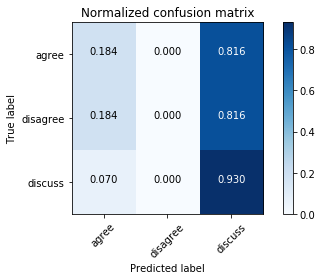

In [345]:
sc.report_score(actual, predicted)
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()